<a href="https://colab.research.google.com/github/Gottyokit/LearningAndPractice/blob/main/SameShit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Valores reales:  [0.20000000298023224, 0.18000000715255737, 0.3199999928474426, 0.30000001192092896, 0.10000000149011612, 0.2800000011920929, 0.2199999988079071, 0.11999999731779099, 0.25, 0.15000000596046448]
Predicciones:  [0.20039573311805725, 0.21789711713790894, 0.23198646306991577, 0.20558728277683258, 0.29583513736724854, 0.19511595368385315, 0.2995155155658722, 0.20538052916526794, 0.15119235217571259, 0.16243675351142883]

Métricas adicionales:
Mean Absolute Error (MAE): 0.0778
Coeficiente de Determinación (R²): -0.6909


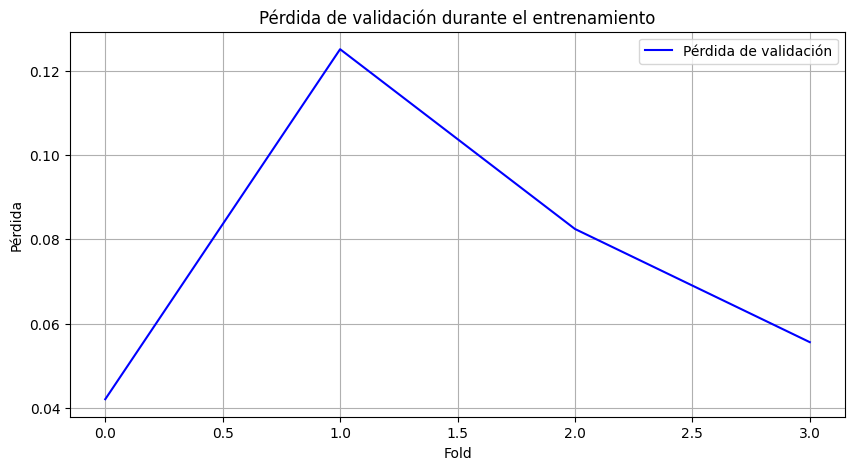

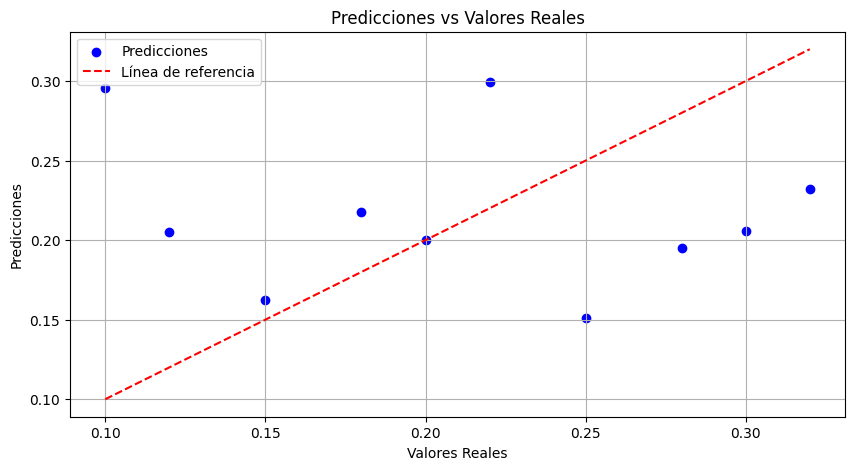

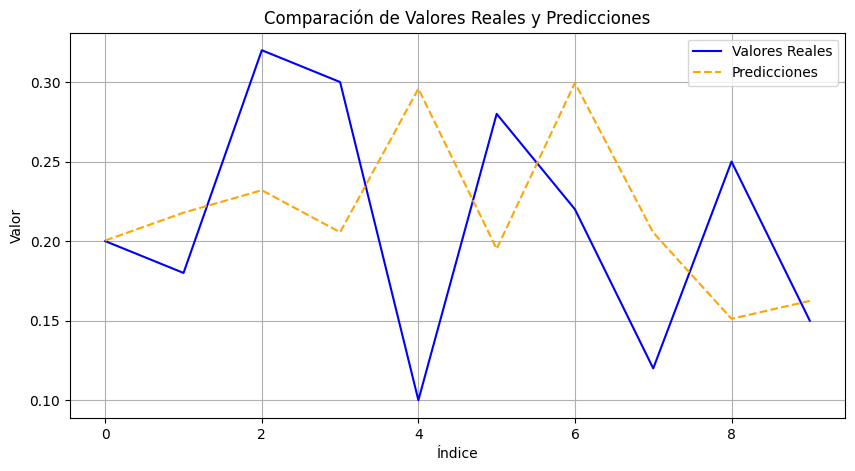

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Generar más datos de entrada y objetivo (sintéticos)
X_train = [
    [27.9, 23.3, 9.54, 303.0, 4254.0, 0],
    [28.3, 26.1, 9.01, 303.0, 8191.0, 0],
    [26.6, 24.6, 9.01, 303.0, 9023.0, 4012],
    [27.2, 22.5, 8.48, 303.0, 4077.0, 0],
    [28.0, 25.0, 9.30, 303.0, 6000.0, 2000],
    [27.5, 24.0, 9.10, 303.0, 7500.0, 1500],
    [26.8, 23.5, 8.90, 303.0, 5000.0, 1000],
    [27.3, 24.8, 9.20, 303.0, 6700.0, 2500],
    [28.1, 25.6, 9.50, 303.0, 7200.0, 3000],
    [26.9, 22.7, 8.70, 303.0, 4800.0, 500]
]

y_train = [0.30, 0.20, 0.10, 0.25, 0.22, 0.18, 0.15, 0.28, 0.32, 0.12]

# Datos de prueba
X_test = [[26.6, 25.7, 9.01, 303.0, 8040.0, 3937]]
y_test = [0.15]

# Escalado de los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir y_train a numpy array para que pueda ser indexado
y_train = np.array(y_train)

# Clase del modelo con regularización (Dropout)
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Dropout con una probabilidad del 30%

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # Aplicar Dropout
        x = self.relu(self.fc2(x))
        x = self.dropout(x)  # Aplicar Dropout
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Lista para almacenar las pérdidas y las predicciones
losses = []
predictions = []
real_values = []

# Configuración del modelo y la validación cruzada
kf = KFold(n_splits=4, shuffle=True, random_state=42)
loss_fn = nn.L1Loss()

for train_index, val_index in kf.split(X_train_scaled):
    # Dividir los datos en folds
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Convertir a tensores de PyTorch
    X_train_fold = torch.tensor(X_train_fold, dtype=torch.float32)
    y_train_fold = torch.tensor(y_train_fold, dtype=torch.float32).view(-1, 1)
    X_val_fold = torch.tensor(X_val_fold, dtype=torch.float32)
    y_val_fold = torch.tensor(y_val_fold, dtype=torch.float32).view(-1, 1)

    # Crear el modelo
    model = NeuralNetwork(X_train_fold.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Entrenamiento
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_fold)
        loss = loss_fn(y_pred, y_train_fold)
        loss.backward()
        optimizer.step()

    # Evaluar el modelo
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val_fold)
        val_loss = loss_fn(y_val_pred, y_val_fold).item()
        losses.append(val_loss)
        predictions.extend(y_val_pred.flatten().tolist())
        real_values.extend(y_val_fold.flatten().tolist())

# Mostrar los valores reales y las predicciones
print("Valores reales: ", real_values)
print("Predicciones: ", predictions)

# Calcular métricas adicionales
mae = mean_absolute_error(real_values, predictions)
r2 = r2_score(real_values, predictions)

print(f"\nMétricas adicionales:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Coeficiente de Determinación (R²): {r2:.4f}")

# Graficar la pérdida durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(losses, label="Pérdida de validación", color='blue')
plt.xlabel("Fold")
plt.ylabel("Pérdida")
plt.title("Pérdida de validación durante el entrenamiento")
plt.legend()
plt.grid(True)
plt.show()

# Graficar predicciones vs valores reales
plt.figure(figsize=(10, 5))
plt.scatter(real_values, predictions, color='blue', label='Predicciones')
plt.plot([min(real_values), max(real_values)], [min(real_values), max(real_values)], color='red', linestyle='--', label='Línea de referencia')
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Predicciones vs Valores Reales")
plt.legend()
plt.grid(True)
plt.show()

# Gráfica de comparación entre valores reales y predicciones (línea continua)
plt.figure(figsize=(10, 5))
plt.plot(real_values, label='Valores Reales', color='blue', linestyle='-')
plt.plot(predictions, label='Predicciones', color='orange', linestyle='--')
plt.xlabel("Índice")
plt.ylabel("Valor")
plt.title("Comparación de Valores Reales y Predicciones")
plt.legend()
plt.grid(True)
plt.show()

